In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Import the necessary libraries.
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
#!pip install pyod            # normal install
#!pip install --upgrade pyod  # or update if needed
from pyod.models.pca import PCA as PCA_PYOD
from pyod.models.kpca import KPCA as KPCA_PYOD
from scipy.io import loadmat
import os
import seaborn as sns


### Vowel 0 or 1 dataset

In [2]:
vowel = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.data'

In [3]:
#Vowel dataset we select the fist and the second vowel
vowel_data = pd.read_csv(vowel,skiprows=2, index_col=False,delim_whitespace=True)
vowel_data.columns = ['feature{}'.format(i) for i in range(0,vowel_data.shape[1])]

vowel_data.shape,vowel_data.nunique().tolist()[-1:]

((987, 14), [11])

In [4]:
Counter(vowel_data['feature13']==0)

Counter({False: 898, True: 89})

In [5]:
#vowel1_dataset.query('feature13 == True')
vowel1_dataset = vowel_data.copy()
vowel1_dataset['feature13']= (vowel1_dataset['feature13']==1)
vowel1_dataset = vowel1_dataset.drop(vowel1_dataset[vowel1_dataset['feature13'] == False].sample(frac=0.96).index)

In [6]:
Counter(vowel1_dataset['feature13'])

Counter({False: 36, True: 89})

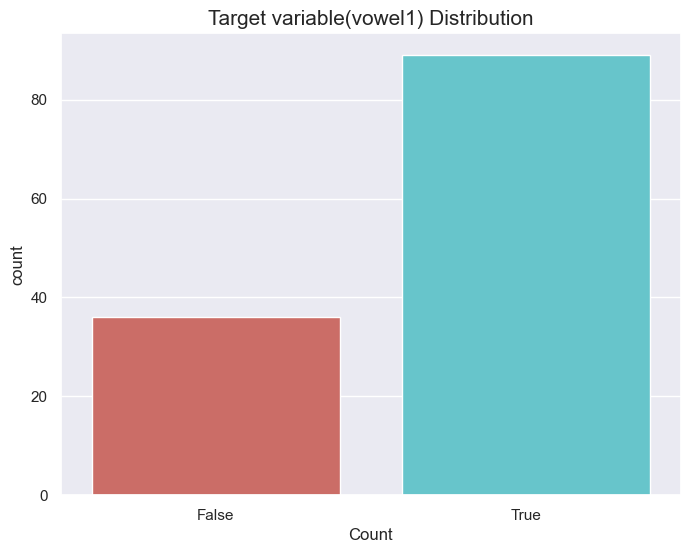

In [7]:
sns.set(rc = {'figure.figsize':(8,6)})
g1 = sns.countplot(x="feature13",data= vowel1_dataset, palette="hls")                  
g1.set_title("Target variable(vowel1) Distribution", fontsize=15)
g1.set_xlabel("Vowel1")
g1.set_xlabel("Count")
plt.show()

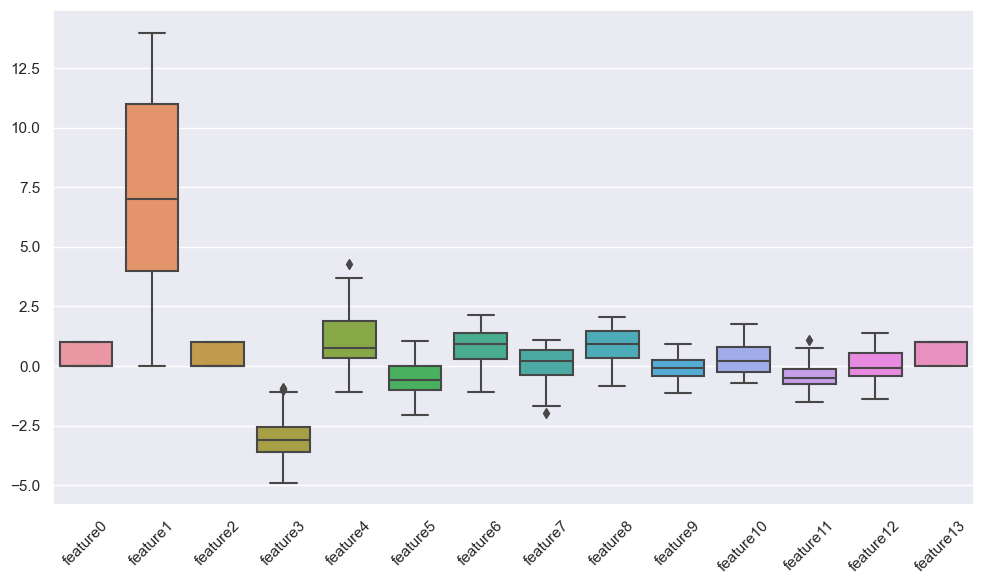

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
box = sns.boxplot(data=vowel1_dataset) 
box.set_xticklabels(box.get_xticklabels(), rotation= 45) 
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

In [9]:
outliers = Counter(vowel1_dataset['feature13'])[0]
inliers = Counter(vowel1_dataset['feature13'])[1]

contamination = outliers/inliers 
contamination

0.4044943820224719

In [10]:
n_features = vowel1_dataset.shape[1]     # number of features

X = vowel1_dataset[vowel1_dataset.columns[:-1]]
y = vowel1_dataset[vowel1_dataset.columns[-1:]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
521,0,7,1,-4.513,4.265,-1.477,-1.090,0.215,0.829,0.342,0.693,-0.601,-0.056
547,1,8,0,-1.784,-1.074,-1.661,1.324,0.289,1.303,0.924,1.307,-0.346,-0.521
339,0,5,1,-3.618,0.916,-0.400,1.771,0.666,1.535,-0.389,-0.342,-1.279,-0.109
317,0,4,1,-3.543,0.624,0.674,1.413,0.653,-0.445,-0.803,-0.256,-0.650,0.423
251,0,3,0,-1.537,0.043,-1.125,-0.213,-0.378,1.265,0.330,0.870,0.293,-0.393


## PCA

In [11]:
#implementation PCA
pca = PCA_PYOD(n_components=2, contamination=contamination) 
pca.fit(X_train)


PCA(contamination=0.4044943820224719, copy=True, iterated_power='auto',
  n_components=2, n_selected_components=None, random_state=None,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False)

In [12]:
# PCA
# get the prediction labels and outlier scores of the training data
y_train_pred_pca = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_pca = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data

# get the prediction labels and outlier scores of the test data
y_test_scores_pca = pca.decision_function(X_test)
y_test_pred_pca = pca.predict(X_test)


In [13]:
pca.get_params()

{'contamination': 0.4044943820224719,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

In [14]:
[pca.explained_variance_,
pca.explained_variance_ratio_]

[array([5.69031105, 2.08227762]), array([0.43268501, 0.15833411])]

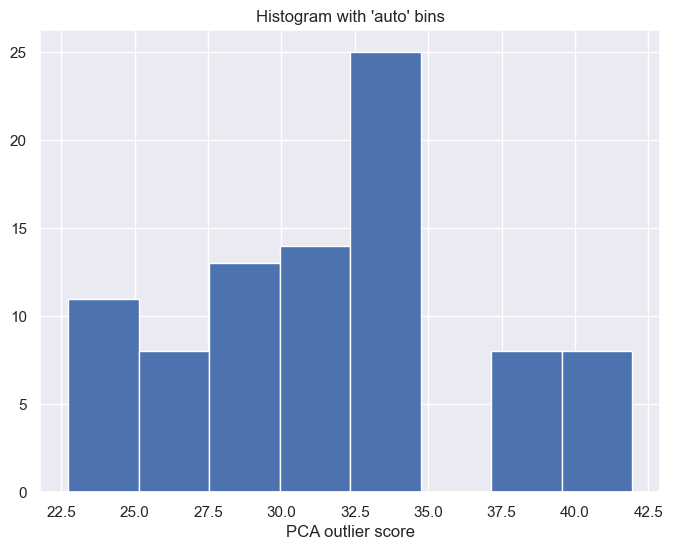

In [15]:
# get the prediction on the test data
y_test_pred_pca = pca.predict(X_test)  # outlier labels (0 or 1)
y_test_scores_pca = pca.decision_function(X_test)  # outlier scores

plt.hist(y_train_scores_pca, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

## Kernel PCA

In [25]:
# KPCA
kpca = KPCA_PYOD(n_components=2, kernel='rbf', gamma=0.15, contamination=contamination)
kpca.fit(X_train)

KPCA(alpha=None, coef0=None, contamination=0.4044943820224719, copy_X=None,
   degree=None, eigen_solver=None, gamma=None, kernel=None,
   kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
   n_selected_components=None,
   random_state=RandomState(MT19937) at 0x106652940, remove_zero_eig=None,
   sampling=False, subset_size=20, tol=None)

In [26]:
# KPCA
# get the prediction labels and outlier scores of the training data
y_train_pred_kpca = kpca.labels_
y_train_scores_kpca = kpca.decision_scores_

# get the prediction labels and outlier scores of the test data
y_test_scores_kpca = kpca.decision_function(X_test)
y_test_pred_kpca = kpca.predict(X_test)

In [27]:
kpca.get_params()

{'alpha': None,
 'coef0': None,
 'contamination': 0.4044943820224719,
 'copy_X': None,
 'degree': None,
 'eigen_solver': None,
 'gamma': None,
 'kernel': None,
 'kernel_params': None,
 'max_iter': None,
 'n_components': 2,
 'n_jobs': None,
 'n_selected_components': None,
 'random_state': RandomState(MT19937) at 0x106652940,
 'remove_zero_eig': None,
 'sampling': False,
 'subset_size': 20,
 'tol': None}

In [28]:
# get the prediction on the test data
y_test_pred_kpca = kpca.predict(X_test)  # outlier labels (0 or 1)
y_test_scores_kpca = kpca.decision_function(X_test)  # outlier scores

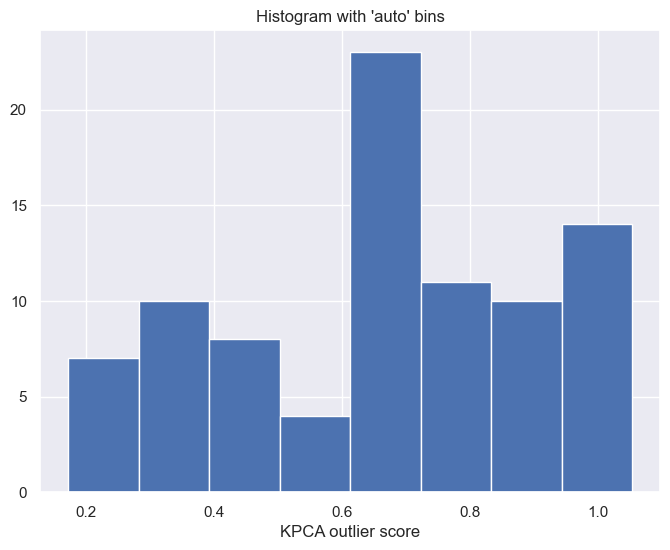

In [29]:
plt.hist(y_train_scores_kpca, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('KPCA outlier score')
plt.show()

### Test other Kernels

In [21]:
# Define a list of kernel functions and parameters to try
"""kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gammas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]"""

In [ ]:
"""# Perform kernelPCA
# Initialize a subplot grid to plot the results
fig, axs = plt.subplots(len(kernels), len(gammas), figsize=(15, 15), constrained_layout=True)

# Loop over the kernels and gammas and perform KPCA
for i, kernel in enumerate(kernels):
    for j, gamma in enumerate(gammas):
        # Initialize the KPCA transformer and fit the data
        kpca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma)
        X_kpca = kpca.fit_transform(X_train)

        # Plot the results
        axs[i, j].scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_train, cmap='viridis', alpha=0.8)
        axs[i, j].set_title(f'{kernel} kernel, gamma={gamma}')

plt.show()"""

## Summary PCA and Kernel PCA

In [30]:
threshold_pca = pca.threshold_
threshold_kpca = kpca.threshold_

print("The threshold of the PCA method for the defined comtanimation rate:" , threshold_pca)
print("The threshold of the KPCA method for the defined comtanimation rate:" , threshold_kpca)

The threshold of the PCA method for the defined comtanimation rate: 32.9839619803445
The threshold of the KPCA method for the defined comtanimation rate: 0.7251217922210131


In [31]:
def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

In [32]:
descriptive_stat_threshold(X_train,y_train_scores_pca, threshold_pca)

,Group,Count,Count %,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,Anomaly_Score
0,Normal,52,59.770115,0.65,8.23,0.42,-2.98,1.17,-0.62,0.79,0.06,0.87,-0.00,0.25,-0.40,-0.11,28.67
1,Outlier,35,40.229885,0.26,6.00,0.66,-3.16,1.21,-0.25,0.98,0.15,0.64,-0.28,0.20,-0.56,0.27,36.42


In [33]:
descriptive_stat_threshold(X_train,y_train_scores_kpca, threshold_kpca)

,Group,Count,Count %,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,Anomaly_Score
0,Normal,52,59.770115,0.62,8.23,0.48,-2.94,0.90,-0.48,1.05,0.29,0.88,-0.18,0.18,-0.54,0.00,0.50
1,Outlier,35,40.229885,0.31,6.00,0.57,-3.22,1.62,-0.45,0.60,-0.19,0.61,-0.01,0.30,-0.35,0.11,0.89


In [ ]:
Actual_pred_pca = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores_pca})
Actual_pred_pca['Pred'] = np.where(Actual_pred_pca['Anomaly_Score']< threshold_pca,0,1)
pd.crosstab(Actual_pred_pca['Actual'],Actual_pred_pca['Pred'])

In [ ]:
Actual_pred_kpca = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores_kpca})
Actual_pred_kpca['Pred'] = np.where(Actual_pred_kpca['Anomaly_Score']< threshold_kpca,0,1)
pd.crosstab(Actual_pred_kpca['Actual'],Actual_pred_kpca['Pred'])

In [ ]:
# fit PCA on training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# create a scatter plot of the projected data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# fit KernelPCA on training data
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01)
X_train_kpca = kpca.fit_transform(X_train)

# create a scatter plot of the projected data
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Kernel Principal Component 1')
plt.ylabel('Kernel Principal Component 2')
plt.show()

## SVM

In [50]:
X = vowel1_dataset[vowel1_dataset.columns[:-1]]
y = vowel1_dataset[vowel1_dataset.columns[-1:]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
521,0,7,1,-4.513,4.265,-1.477,-1.090,0.215,0.829,0.342,0.693,-0.601,-0.056
547,1,8,0,-1.784,-1.074,-1.661,1.324,0.289,1.303,0.924,1.307,-0.346,-0.521
339,0,5,1,-3.618,0.916,-0.400,1.771,0.666,1.535,-0.389,-0.342,-1.279,-0.109
317,0,4,1,-3.543,0.624,0.674,1.413,0.653,-0.445,-0.803,-0.256,-0.650,0.423
251,0,3,0,-1.537,0.043,-1.125,-0.213,-0.378,1.265,0.330,0.870,0.293,-0.393


In [51]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [52]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)

In [53]:
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]

In [54]:
# Check the model performance
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

       False       0.25      0.73      0.37        11
        True       0.50      0.11      0.18        27

    accuracy                           0.29        38
   macro avg       0.38      0.42      0.28        38
weighted avg       0.43      0.29      0.24        38



In [55]:
print("The accuracy score predicted is {}".format(accuracy_score(y_test, prediction)))

The accuracy score predicted is 0.2894736842105263


In [56]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)
score

array([0.1340326 , 0.13014792, 0.13268194, 0.13769233, 0.13785764,
       0.12966807, 0.11980397, 0.13133355, 0.13028042, 0.12640262,
       0.12275883, 0.13539139, 0.13829005, 0.09817381, 0.13373989,
       0.13224387, 0.13584206, 0.14585483, 0.10923759, 0.13648002,
       0.13303308, 0.1313691 , 0.13737522, 0.12950997, 0.14260867,
       0.12877597, 0.13954628, 0.11667205, 0.13410012, 0.13568675,
       0.13674809, 0.13437671, 0.15102074, 0.15542532, 0.12814007,
       0.12208386, 0.13015362, 0.13390211])

In [57]:
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
score_threshold

0.10636100854967746

In [58]:
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')

The customized score threshold for 2% of outliers is 0.11


In [60]:
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

              precision    recall  f1-score   support

       False       0.27      0.91      0.42        11
        True       0.00      0.00      0.00        27

    accuracy                           0.26        38
   macro avg       0.14      0.45      0.21        38
weighted avg       0.08      0.26      0.12        38

